![](https://user-images.githubusercontent.com/8117267/116876711-8defc300-ac25-11eb-8b7b-5eab8860602c.png)

# SMPLpix Dataset Preparation.

**Author**: [Sergey Prokudin](https://ps.is.mpg.de/people/sprokudin).
[[Project Page](https://sergeyprokudin.github.io/smplpix/)]
[[Paper](https://arxiv.org/pdf/2008.06872.pdf)]
[[Video](https://www.youtube.com/watch?v=JY9t4xUAouk)]
[[GitHub](https://github.com/sergeyprokudin/smplpix)]

This notebook contains an example workflow for converting a video file to a SMPLpix dataset.
### Processing steps:

1. Download the video of choice, extract frames;
2. Extract **2D keypoints**: run [OpenPose](https://github.com/CMU-Perceptual-Computing-Lab/openpose) on the extracted frames;
3. Infer **3D human meshes**: run [SMPLify-x](https://github.com/vchoutas/smplify-x) on the extracted frames + keypoints;
4. Form dataset **image pairs**, where *input* is SMPL-X mesh render, and *output* is the corresponding target ground truth video frame;
5. **Split the data** into train, test and validation, zip and copy to Google Drive.

### Instructions

1. Convert a video into our dataset format using this notebook.
2. Train a SMPLpix using the training notebook.


### Notes
* While this will work for small datasets in a Colab runtime, larger datasets will require more compute power;
* If you would like to train a model on a serious dataset, you should consider copying this to your own workstation and running it there. Some minor modifications will be required, and you will have to install the dependencies separately;
* Please report issues on the [GitHub issue tracker](https://github.com/sergeyprokudin/smplpix/issues).

If you find this work useful, please consider citing:
```bibtex
@inproceedings{prokudin2021smplpix,
  title={SMPLpix: Neural Avatars from 3D Human Models},
  author={Prokudin, Sergey and Black, Michael J and Romero, Javier},
  booktitle={Proceedings of the IEEE/CVF Winter Conference on Applications of Computer Vision},
  pages={1810--1819},
  year={2021}
}
```

Many thanks [Keunhong Park](https://keunhong.com) for providing the [Nerfie dataset preparation template](https://colab.research.google.com/github/google/nerfies/blob/main/notebooks/Nerfies_Capture_Processing.ipynb)!


## Upload the video and extract frames


In [13]:
# @title Upload a video file (.mp4, .mov, etc.) from your disk, Dropbox, Google Drive or YouTube

# @markdown  This will upload it to the local Colab working directory. You can use a demo video to test the pipeline. The background in the demo was removed with the [Unscreen](https://www.unscreen.com/) service. Alternatively, you can try [PointRend](https://github.com/facebookresearch/detectron2/tree/master/projects/PointRend) segmentation for this purpose.

import os
from google.colab import files

def download_youtube_video(img_url, save_path, resolution_id=-3):

  print("downloading the video: %s" % img_url)
  res_path = YouTube(img_url).streams.order_by('resolution')[resolution_id].download(save_path)

  return res_path

def download_dropbox_url(url, filepath, chunk_size=1024):

    import requests
    headers = {'user-agent': 'Wget/1.16 (linux-gnu)'}
    r = requests.get(url, stream=True, headers=headers)
    with open(filepath, 'wb') as f:
        for chunk in r.iter_content(chunk_size=chunk_size):
            if chunk:
                f.write(chunk)
    return filepath

!rm -rf /content/data

from google.colab import drive
drive.mount('/content/gdrive')

VIDEO_SOURCE = 'dropbox' #@param ["youtube", "upload", "google drive", "dropbox"]

if VIDEO_SOURCE == 'dropbox':
  DROPBOX_URL  = 'https://www.dropbox.com/s/rjqwf894ovso218/smplpix_test_video_na.mp4?dl=0' #@param
  VIDEO_PATH  = '/content/video.mp4'
  download_dropbox_url(DROPBOX_URL, VIDEO_PATH)
elif VIDEO_SOURCE == 'upload':
  print("Please upload the video: ")
  uploaded = files.upload()
  VIDEO_PATH = os.path.join('/content', list(uploaded.keys())[0])
elif VIDEO_SOURCE == 'youtube':
  !pip install pytube
  from pytube import YouTube
  YOTUBE_VIDEO_URL  = ''  #@param
  VIDEO_PATH = download_youtube_video(YOTUBE_VIDEO_URL, '/content/')
elif VIDEO_SOURCE == 'google drive':
  from google.colab import drive
  drive.mount('/content/gdrive')
  GOOGLE_DRIVE_PATH = '/content/video.mp4' #@param
  VIDEO_PATH  = GOOGLE_DRIVE_PATH


print("video is uploaded to %s" % VIDEO_PATH)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
video is uploaded to /content/video.mp4


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

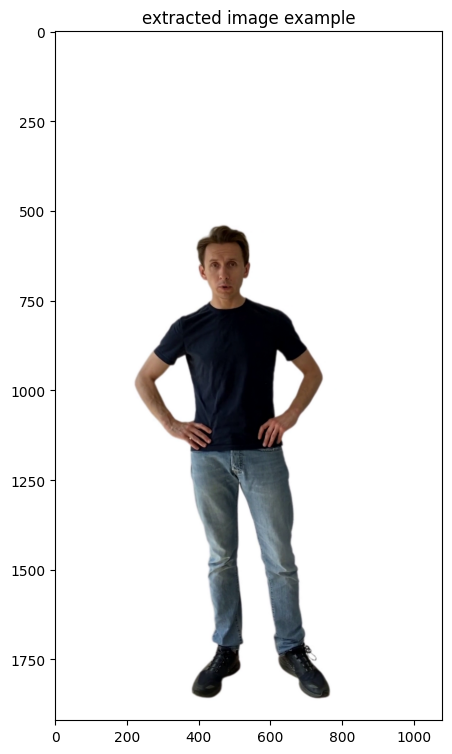

In [15]:
# @title Flatten the video into frames


FPS =     1# @param {type:'number'}

# @markdown _Note_: for longer videos, it might make sense to decrease the FPS as it will take 30-60 seconds for SMPLify-X framework to process every frame.



RES_DIR = '/content/data'
FRAMES_DIR = os.path.join(RES_DIR, 'images')
!rm -rf $RES_DIR
!mkdir $RES_DIR
!mkdir $FRAMES_DIR
!ffmpeg -i "$VIDEO_PATH" -vf fps=$FPS  -qscale:v 2 "$FRAMES_DIR/%05d.png"

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def load_img(img_path):

  return np.asarray(Image.open(img_path))/255

print(os.listdir(FRAMES_DIR))

test_img_path = os.path.join(FRAMES_DIR, os.listdir(FRAMES_DIR)[0])

test_img = load_img(test_img_path)

plt.figure(figsize=(5, 10))
plt.title("extracted image example")
plt.imshow(test_img)

## Extract 2D body keypoints with OpenPose



In [3]:
# @title Install OpenPose
# @markdown This will take some time (~10 mins). The code is taken from this [OpenPose Colab notebook](https://colab.research.google.com/github/tugstugi/dl-colab-notebooks/blob/master/notebooks/OpenPose.ipynb).

%cd /content
import os
from os.path import exists, join, basename, splitext

git_repo_url = 'https://github.com/CMU-Perceptual-Computing-Lab/openpose.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # see: https://github.com/CMU-Perceptual-Computing-Lab/openpose/issues/949
  # install new CMake becaue of CUDA10
  !wget -q https://cmake.org/files/v3.13/cmake-3.13.0-Linux-x86_64.tar.gz
  !tar xfz cmake-3.13.0-Linux-x86_64.tar.gz --strip-components=1 -C /usr/local

  # clone openpose
  !git clone -q --depth 1 $git_repo_url
  !sed -i 's/execute_process(COMMAND git checkout master WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/execute_process(COMMAND git checkout f019d0dfe86f49d1140961f8c7dec22130c83154 WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/g' openpose/CMakeLists.txt
  # install system dependencies
  !apt-get -qq install -y libatlas-base-dev libprotobuf-dev libleveldb-dev libsnappy-dev libhdf5-serial-dev protobuf-compiler libgflags-dev libgoogle-glog-dev liblmdb-dev opencl-headers ocl-icd-opencl-dev libviennacl-dev
  # install python dependencies
  !pip install -q youtube-dl
  # build openpose
  !cd openpose && rm -rf build || true && mkdir build && cd build && cmake .. && make -j`nproc`


/content
Selecting previously unselected package liblmdb0:amd64.
(Reading database ... 124935 files and directories currently installed.)
Preparing to unpack .../00-liblmdb0_0.9.24-1build2_amd64.deb ...
Unpacking liblmdb0:amd64 (0.9.24-1build2) ...
Selecting previously unselected package libgflags2.2.
Preparing to unpack .../01-libgflags2.2_2.2.2-2_amd64.deb ...
Unpacking libgflags2.2 (2.2.2-2) ...
Selecting previously unselected package libgflags-dev.
Preparing to unpack .../02-libgflags-dev_2.2.2-2_amd64.deb ...
Unpacking libgflags-dev (2.2.2-2) ...
Selecting previously unselected package libgoogle-glog0v5.
Preparing to unpack .../03-libgoogle-glog0v5_0.5.0+really0.4.0-2_amd64.deb ...
Unpacking libgoogle-glog0v5 (0.5.0+really0.4.0-2) ...
Selecting previously unselected package libunwind-dev:amd64.
Preparing to unpack .../04-libunwind-dev_1.3.2-2build2.1_amd64.deb ...
Unpacking libunwind-dev:amd64 (1.3.2-2build2.1) ...
Selecting previously unselected package libgoogle-glog-dev.
Prepar

In [ ]:
# @title Run OpenPose on the extracted frames
%cd /content
KEYPOINTS_DIR = os.path.join(RES_DIR, 'keypoints')
OPENPOSE_IMAGES_DIR = os.path.join(RES_DIR, 'openpose_images')
!mkdir $KEYPOINTS_DIR
!mkdir $OPENPOSE_IMAGES_DIR

!cd openpose && ./build/examples/openpose/openpose.bin --image_dir $FRAMES_DIR --write_json $KEYPOINTS_DIR --face --hand --display 0   --write_images $OPENPOSE_IMAGES_DIR

input_img_path = os.path.join(FRAMES_DIR, sorted(os.listdir(FRAMES_DIR))[0])
openpose_img_path = os.path.join(OPENPOSE_IMAGES_DIR, sorted(os.listdir(OPENPOSE_IMAGES_DIR))[0])

test_img = load_img(input_img_path)
open_pose_img = load_img(openpose_img_path)

plt.figure(figsize=(10, 10))
plt.title("Input Frame + Openpose Prediction")
plt.imshow(np.concatenate([test_img, open_pose_img], 1))


## Infer 3D Human Model with [SMPLify-X](https://smpl-x.is.tue.mpg.de/)

In [ ]:
# @title Install SMPLify-X and other dependencies

%cd /content
!pip install chumpy
!pip install smplx
!git clone https://github.com/vchoutas/smplx
%cd smplx
!python setup.py install

#vposer
!pip install git+https://github.com/nghorbani/configer
!pip install git+https://github.com/sergeyprokudin/human_body_prior

!pip install torch==1.1.0
%cd /content
!git clone https://github.com/sergeyprokudin/smplify-x
%cd /content/smplify-x
!pip install -r requirements.txt

In [ ]:
# @title Upload the SMPL-X model files

# @markdown Proceed to the [official website](https://smpl-x.is.tue.mpg.de/), register and download the zip files with SMPL-X (**models_smplx_v1_1.zip**, ~830MB) and VPoser (**vposer_v1_0.zip**, ~2.5MB) models from the **Downloads** section.
# @markdown

# @markdown Since uploading large zip files to Colab is relatively slow, we expect you to upload these files to Google Drive instead, link gdrive to the Colab file systems and modify **SMPLX_ZIP_PATH** and **VPOSER_ZIP_PATH** variables accordingly.

%cd /content/
from google.colab import drive
drive.mount('/content/gdrive')

SMPLX_ZIP_PATH = '/content/gdrive/MyDrive/datasets/models_smplx_v1_1.zip' # @param {type:"string"}
VPOSER_ZIP_PATH = '/content/gdrive/MyDrive/datasets/vposer_v1_0.zip' # @param {type:"string"}

SMPLX_MODEL_PATH = '/content/smplx'
!mkdir $SMPLX_MODEL_PATH
!unzip -n '$SMPLX_ZIP_PATH' -d  $SMPLX_MODEL_PATH
VPOSER_MODEL_PATH = '/content/vposer'
!mkdir $VPOSER_MODEL_PATH
!unzip -n '$VPOSER_ZIP_PATH' -d  $VPOSER_MODEL_PATH

In [ ]:
# @title Run SMPLify-X

# @markdown Please select gender of the SMPL-X model:

gender = 'male' #@param ["neutral", "female", "male"]

# @markdown Please keep in mind that estimating 3D body with SMPLify-X framework will take ~30-60 secs, so processing long videos at high FPS might take a long time.

!rm -rf /content/data/smplifyx_results
%cd /content/smplify-x
!git pull origin
!python smplifyx/main.py --config cfg_files/fit_smplx.yaml \
    --data_folder  /content/data \
    --output_folder /content/data/smplifyx_results \
    --visualize=True \
    --gender=$gender \
    --model_folder /content/smplx/models \
    --vposer_ckpt /content/vposer/vposer_v1_0 \
    --part_segm_fn smplx_parts_segm.pkl

In [ ]:
# @title Make train-test-validation splits, copy data to final folders

import shutil

train_ratio = 0.9 #@param

final_zip_path = '/content/gdrive/MyDrive/datasets/smplpix_data_test.zip' # @param {type:"string"}


target_images_path = '/content/data/smplifyx_results/input_images'
smplifyx_renders = '/content/data/smplifyx_results/rendered_smplifyx_meshes'

smplpix_data_path = '/content/smplpix_data'

train_input_dir = os.path.join(smplpix_data_path, 'train', 'input')
train_output_dir = os.path.join(smplpix_data_path, 'train', 'output')
val_input_dir = os.path.join(smplpix_data_path, 'validation', 'input')
val_output_dir = os.path.join(smplpix_data_path, 'validation', 'output')
test_input_dir = os.path.join(smplpix_data_path, 'test', 'input')
test_output_dir = os.path.join(smplpix_data_path, 'test', 'output')

!mkdir -p $train_input_dir
!mkdir -p $train_output_dir
!mkdir -p $val_input_dir
!mkdir -p $val_output_dir
!mkdir -p $test_input_dir
!mkdir -p $test_output_dir

img_names = sorted(os.listdir(target_images_path))
n_images = len(img_names)
n_train_images = int(n_images * train_ratio)
n_val_images = int(n_images * (1-train_ratio) / 2)
train_images = img_names[0:n_train_images]
val_images = img_names[n_train_images:n_train_images+n_val_images]
test_images = img_names[n_train_images:]

for img in train_images:
  shutil.copy(os.path.join(smplifyx_renders, img), train_input_dir)
  shutil.copy(os.path.join(target_images_path, img), train_output_dir)

for img in val_images:
  shutil.copy(os.path.join(smplifyx_renders, img), val_input_dir)
  shutil.copy(os.path.join(target_images_path, img), val_output_dir)

for img in test_images:
  shutil.copy(os.path.join(smplifyx_renders, img), test_input_dir)
  shutil.copy(os.path.join(target_images_path, img), test_output_dir)


%cd /content
!zip -r $final_zip_path smplpix_data/